# Goodness-of-fit test with Combine
Assuming background model is rejected events (fail VAE cut) miltiplied by some transfer factor (single number or function of dijet invariant mass)

In [1]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import pandas
from math import log10, floor
from subprocess import Popen
import shlex 
#import cmsstyle

Welcome to JupyROOT 6.12/07


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-root_numpy/4.7.3-gnimlf6/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.6 is currently installed but you installed root_numpy against numpy 1.14.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
# Set some important variables

# Rescaling the inputs to lumi
qcd_xsec       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec       = 10. #In units of fb (== 0.01 pb) 
sig_gen_events = 972050.0 #(all generated signal)
lumi           = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = 0.8*sig_xsec*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

# Set binning
useDijet = False #DOESN'T WORK FOR GOF!!! Only use for plotting
# Dijet variable-binwidth binning (depends on dijet resolution)
if useDijet:
    histfile = 'histograms_dijet.root'
    wsfile   = 'datacard_ws_dijet'   #only prefix
#     bin_edges = np.array([1126,1181,1246,1313,1383,1455,1530,
#                           1607,1687,1770,1856,1945,2037,2132,
#                           2231,2332,2438,2546,2659,2775,2895,
#                           3019,3147,3279,3416,3558,3704,3854,
#                           4010,4171,4337,4509,4686,4869,5058,
#                           5253,5500,5663,5877,6099,6328,6564,6808]).astype('float')
    #Use  latest binning
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327,
                          5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')

# Constant binwidth
else:
    histfile = 'histograms_100GeV_5500.root'
    wsfile   = 'datacard_ws_100GeV_5500'   
    bin_edges = np.array(np.arange(1200.,5600., 100.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800
print(bin_edges)
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

# Signal strengths to inject for statistical test
# Define some signal parameters
MX = 2500. #Signal mass in units of GeV
sig_inj_vals = [10]#[0,0.1, 1, 2,5,10] #These correspond to xsecs of 0fb(used for GOF w.o signal), 1fb, 10fb, 20fb, 50fb, 100fb

# Where to save data histograms and workspace+datacards


#quantiles
quants = [0.01,0.1,0.3,0.5,0.7,0.9]

#Color style
scol = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
scol.reverse()
bcol = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824'] 
bcol.reverse()

Usign luminosity 63.981237457
Scale QCD with 1.0
Scale signal with 0.000526567460168
[1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500.]


In [3]:
#  Get the total, accepted and rejected events for signal and data
mG = str(MX)[0]
xsec_str = '100'
path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_113/sig_GtoWW'+mG+'5naReco/xsec_'+xsec_str+'/loss_rk5_05/'

f_qcd = h5py.File(path+'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5', 'r')
f_sig = h5py.File(path+'RSGraviton_WW_NARROW_13TeV_PU40_'+mG+'.5TeV_reco.h5', 'r')

print(f_qcd.keys())
print(list(f_qcd.get("eventFeatureNames")))
print('N QCD events = {}'.format(len(f_qcd.get("eventFeatures"))))

[u'eventFeatureNames', u'eventFeatures']
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss', 'sel_q90', 'sel_q70', 'sel_q50', 'sel_q30', 'sel_q10', 'sel_q01']
N QCD events = 7671759


In [4]:
# Define which columns represent whiich variaibles

mjj_idx = int(np.where(f_qcd['eventFeatureNames'][()] == 'mJJ')[0])
deta_idx = int(np.where(f_sig['eventFeatureNames'][()] == 'DeltaEtaJJ')[0])

# Different quantiles (not yet orthogonal!)
columns   = {}
columns[0.9]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q90')[0]) # 0=rejected 1=accepted
columns[0.7]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
columns[0.5]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q50')[0])
columns[0.3]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q30')[0])
columns[0.1]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q10')[0])
columns[0.01] = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q01')[0])


# Get all features as numpy arrays and apply dEta cut
qcd_tot = np.array(f_qcd.get("eventFeatures"))
sig_tot = np.array(f_sig.get("eventFeatures"))
print('No dEta cut Total = {}'.format(sig_tot.shape[0]))
print('No dEta cut pass q 1% = {}'.format(sig_tot[sig_tot[:,columns[0.01]] == 1].shape[0]))
qcd_tot = qcd_tot[abs(qcd_tot[:,deta_idx]) < 1.40]
sig_tot = sig_tot[abs(sig_tot[:,deta_idx]) < 1.40]
print('With dEta cut Total = {}'.format(sig_tot.shape[0]))
print('With dEta cut pass q 1% = {}'.format(sig_tot[sig_tot[:,columns[0.01]] == 1].shape[0]))

No dEta cut Total = 492361
No dEta cut pass q 1% = 15027
With dEta cut Total = 492361
With dEta cut pass q 1% = 15027


In [5]:
# Define the different dijet invariant mass datasets (total, orthogonal quantiles)
datas_qcd_acc = {}
datas_sig_acc = {}

sig_all      = sig_tot[:,mjj_idx]
qcd_all      = qcd_tot[:,mjj_idx]

#Define the main templates as the 'unused quantile' at 90-100% background efficiency
qcd_template = qcd_tot[qcd_tot[:,columns[0.9]] == 0]
qcd_template = qcd_template[:,mjj_idx]
sig_template = sig_tot[sig_tot[:,columns[0.9]] == 0]
sig_template = sig_template[:,mjj_idx]

# Make sure all quantiles are orthogonal (removing events passing q-1 from q distribution)
qcd = np.copy(qcd_tot)
sig = np.copy(sig_tot)

for key in sorted(columns.keys()):
    
    # Start with q=0.01 and take all events that pass cut on VAE
    datas_qcd_acc[key] = qcd[qcd[:,columns[key]] == 1]
    datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]
    
    datas_sig_acc[key] = sig[sig[:,columns[key]] == 1]
    datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]
    
    #Remove those events from dataset and continue to next quantile
    qcd = qcd[qcd[:,columns[key]] == 0]
    sig = sig[sig[:,columns[key]] == 0]


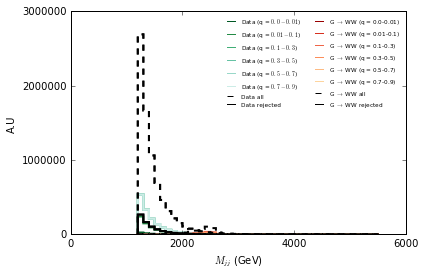

In [6]:
#Some quick control plots to check shapes

from matplotlib.lines import Line2D

fig, ax = plt.subplots()

for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_qcd_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_qcd_acc[key],bins=bin_edges,label=r'Data (q = ${}-{}$)'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=bcol[i],fill=True)
plt.hist(qcd_all,bins=bin_edges,label=r'Data all',histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True)
plt.hist(qcd_template,bins=bin_edges,label=r'Data rejected',histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True)
       
for i,key in enumerate(sorted(datas_sig_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_sig_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_sig_acc[key],bins=bin_edges,label=r'G $\rightarrow$ WW (q = {}-{})'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=scol[i],fill=True)
    
plt.hist(sig_all,bins=bin_edges,label=r'G $\rightarrow$ WW all',histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True)
plt.hist(sig_template,bins=bin_edges,label=r'G $\rightarrow$ WW rejected',histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True)
plt.hist(qcd_all,bins=bin_edges,histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True)
plt.hist(qcd_template,bins=bin_edges,histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True)
    
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor(),linestyle=h.get_linestyle()) for h in handles]
plt.ylabel('A.U')
plt.xlabel(u'$M_{jj}$ (GeV)')
plt.locator_params(nbins=4)
plt.legend(handles=new_handles, labels=labels,loc='best',frameon=False, ncol=2,fontsize='xx-small')
plt.savefig('signal_shapes_nolog.pdf')

In [7]:
# Sanity checks

#Check that sum of orthogonal quantiles yield total
print('N total data events = {}'.format(qcd_tot.shape[0]))
sum_quantiles = 0
for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    sum_quantiles += datas_qcd_acc[key].shape[0]
print('Sum of all events up to 90th quantile = {}'.format(sum_quantiles))
print('Sum of all events between 90th-100th quantile = {}'.format(qcd_template.shape[0]))
print('N_total - N_1to90 - N_90to100 = {}'.format(qcd_tot.shape[0]-sum_quantiles-qcd_template.shape[0]))

N total data events = 7671753
Sum of all events up to 90th quantile = 6905577
Sum of all events between 90th-100th quantile = 766176
N_total - N_1to90 - N_90to100 = 0


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


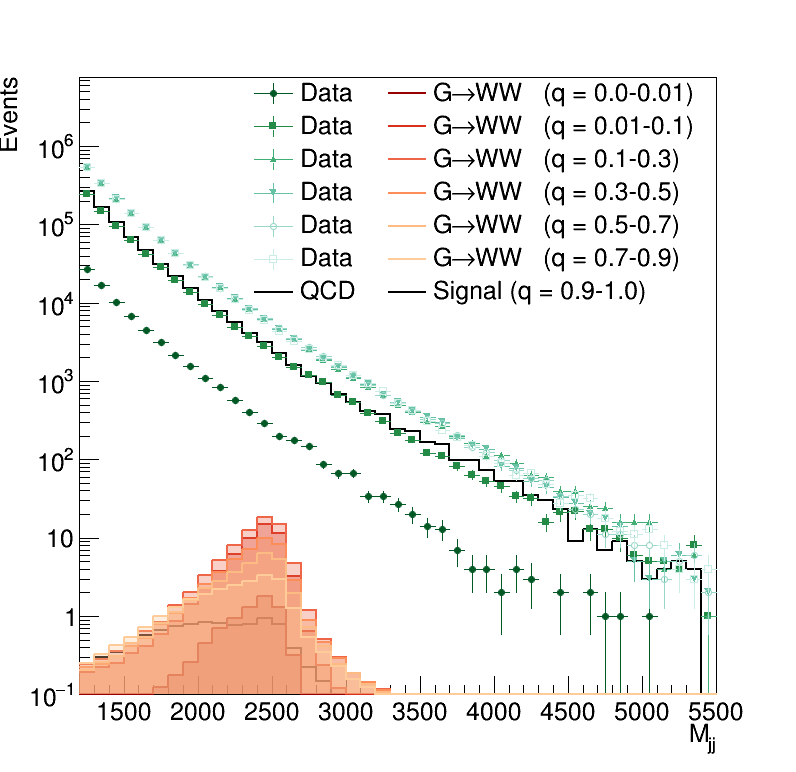

In [8]:
# Fill histograms using dijet binning and proper lumi scaling.
#These are the baseline histograms for statistical analysis.
axis_title = ['M_{jj}','Events']

#Fill and scale to lumi
background_hist_template = rt.TH1D('background_hist_template','background_hist_template',n_bins,bin_edges.astype('float'))
data_rejected = rt.TH1D('data_rejected','data_rejected',n_bins,bin_edges.astype('float'))

rtnp.fill_hist(background_hist_template, qcd_template, weights=None)
rtnp.fill_hist(data_rejected, qcd_template, weights=None)
# background_hist_template.Scale(scale_qcd)
background_hist_template.SetStats(0)
background_hist_template.Sumw2()
signal_hist_template     = rt.TH1D('signal_rej'    ,'signal_rej'    ,n_bins,bin_edges.astype('float'))
rtnp.fill_hist(signal_hist_template    , sig_template, weights=None)
signal_hist_template.Scale(scale_sig)
signal_hist_template.SetStats(0)
signal_hist_template.Sumw2()

background_hist_template.SetXTitle(axis_title[0])
background_hist_template.SetYTitle(axis_title[1])
background_hist_template.binning = bin_edges
background_hist_template.SetLineColor(rt.kBlack)
background_hist_template.SetLineColor(rt.kBlack)
background_hist_template.SetLineStyle(rt.kSolid)
background_hist_template.SetLineWidth(2)

leg = rt.TLegend(0.31, 0.6, 0.85, 0.9)
leg.SetNColumns(2)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

histos_data = {}
histos_signal = {}
scol = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
scol.reverse()
bcol = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824'] 
bcol.reverse()
colors = ['#d55e00','#cc79a7','#0072b2','#f0e442','#009e73','#b3de69','#fccde5','#d9d9d9']
i = 0
for keyD,keyS in zip( sorted(datas_qcd_acc.keys()), sorted(datas_sig_acc.keys()) ):
    histos_data[keyD]  = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
    histos_signal[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
    rtnp.fill_hist(histos_data[keyD]   , datas_qcd_acc[keyD], weights=None)
    rtnp.fill_hist(histos_signal[keyS] , datas_sig_acc[keyS], weights=None)
    
#     .histos_data[keyD].Scale(scale_qcd)
    histos_signal[keyS].Scale(scale_sig)
    
    histos_data[keyD]  .SetStats(0)
    histos_signal[keyS].SetStats(0)
    
#     histos_data[keyD].SetBinErrorOption(rt.TH1.kPoisson)
    histos_data[keyD].Sumw2()
    histos_signal[keyS].Sumw2()

    histos_data[keyD].SetXTitle(axis_title[0])
    histos_data[keyD].SetYTitle(axis_title[1])
    histos_data[keyD].binning = bin_edges
    
    histos_signal[keyS].SetXTitle(axis_title[0])
    histos_signal[keyS].SetYTitle(axis_title[1])
    histos_signal[keyS].binning = bin_edges
    
    histos_data[keyD].SetLineColor(rt.TColor.GetColor(bcol[i]))
    histos_data[keyD].SetMarkerColor(rt.TColor.GetColor(bcol[i]))
    
    histos_signal[keyS].SetLineColor(rt.TColor.GetColor(scol[i]))
    histos_signal[keyS].SetLineStyle(rt.kSolid)
    histos_signal[keyS].SetLineWidth(2)
    histos_signal[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[i])), 0.30)

    histos_data[keyD].SetMarkerStyle(20+i)
    histos_data[keyD].SetMarkerSize(0.9)
    i += 1


#Draw
c = rt.TCanvas('c','c',800,800)
background_hist_template.Draw('HIST')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.1)
background_hist_template.SetMaximum(qcd_tot.shape[0])
signal_hist_template.SetLineColor(rt.kBlack)
signal_hist_template.SetLineStyle(rt.kSolid)
signal_hist_template.SetLineWidth(2)
signal_hist_template.Draw('HISTsame')
# signal_hist_template    .Draw('same HIST')

for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
       lower_bound = 0.0 
#     leg.AddEntry(histos_data[key], 'Data (q = {}-{})'.format(lower_bound,key), 'lep')
    leg.AddEntry(histos_data[key], 'Data    ', 'lep')
    leg.AddEntry(histos_signal[key], 'G#rightarrowWW   (q = {}-{})'.format(lower_bound,key), 'l')
    histos_data[key].Draw('pez same')
#     histos_signal[key].Scale(10000.)
    histos_signal[key].Draw('HIST same')   
leg.AddEntry(background_hist_template , 'QCD', 'l')   
leg.AddEntry(signal_hist_template , 'Signal (q = 0.9-1.0)', 'l') 
c.SetLogy()
c.SetTitle('')

leg.Draw("same")
c.Draw()

0


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_all25_xsec100.pdf has

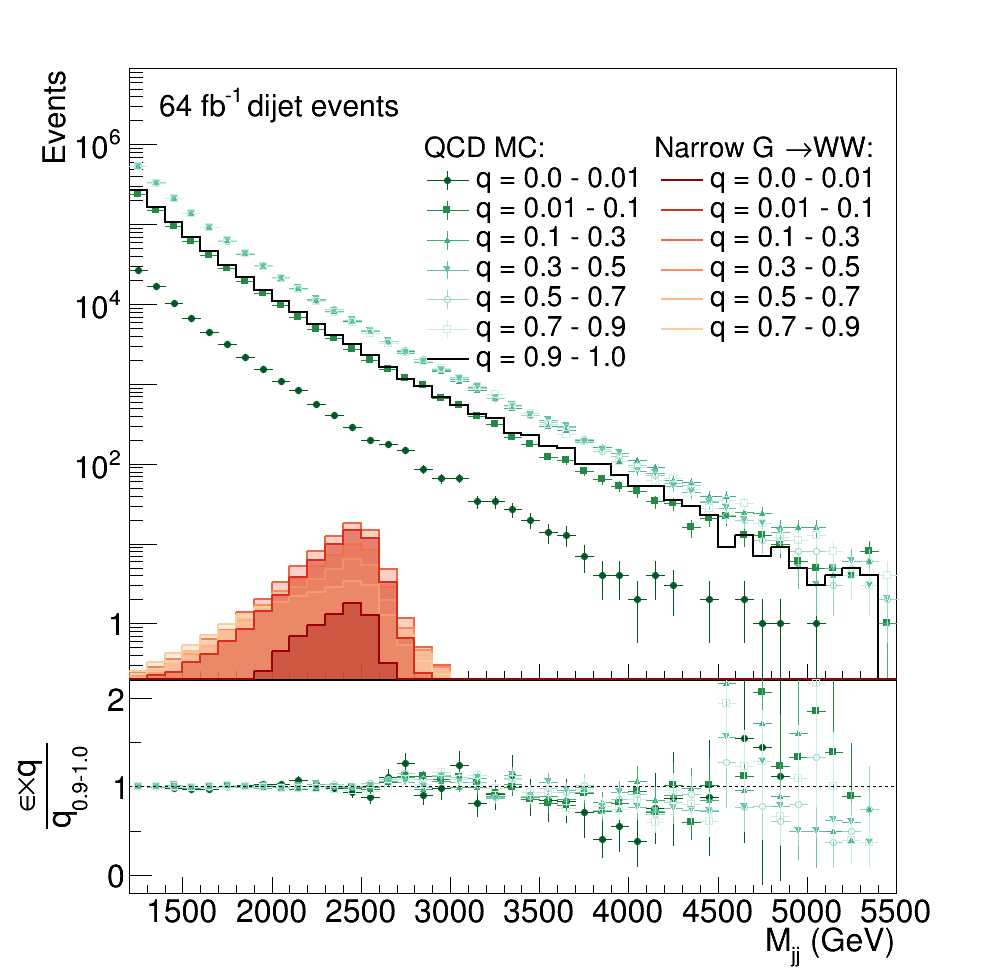

In [9]:
# Draw "nice" ratio plot for paper, check efficiency quantile/template and smoothness
#import mplhep # cmsstyle #for Python2 cheatsheet

c_out = rt.TCanvas("ratio", "", 1000, 1000)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
# pad1.SetGridx()
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.42, 0.45, 0.89, 0.80)
leg.SetNColumns(2)
leg.SetTextSize(0.045)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

background_hist_template.Draw('HIST')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.2)
background_hist_template.GetYaxis().SetTitleSize(0.05)
background_hist_template.GetYaxis().SetLabelSize(0.05)
background_hist_template.GetYaxis().SetTitleOffset(0.95)
background_hist_template.SetMaximum(qcd_tot.shape[0]*1.2)
background_hist_template.GetYaxis().SetNdivisions(304)
# background_hist_template.GetYaxis().SetLabelSize(0.05)
# background_hist_template.GetYaxis().SetTitleSize(0.05)
# signal_hist_template    .Draw('same HIST')
# leg.SetTextSize (0.03)
# leg.SetTextFont( 62 )
leg.SetHeader('QCD MC:              Narrow G#rightarrowWW:')
# leg.SetTextSize (0.03)
# leg.SetTextFont( 42 )
for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
       lower_bound = 0.0 
    histos_data[key].Draw('pez same')
    histos_signal[key].Draw('HIST same')
    leg.AddEntry(histos_data[key]  , 'q = {} - {}'.format(lower_bound,key), 'lep')
    leg.AddEntry(histos_signal[key], 'q = {} - {}'.format(lower_bound,key), 'l')
background_hist_template.Draw('same HIST')
histos_signal[0.1].Draw('HIST same')
histos_signal[0.01].Draw('HIST same')
# leg.SetTextSize(0.04)  
leg.AddEntry(background_hist_template , 'q = 0.9 - 1.0', 'l') 
leg.Draw('same')

pad1.SetLogy()
pad1.SetTitle('')

c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio = {}
tline = {}
for i,key in enumerate(sorted(histos_data.keys())):
    pad2.cd()
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
    histos_data[key].Sumw2()
    data_hist_ratio[key] = histos_data[key].Clone('data_hist_ratio_{}'.format(i))
    background_hist_template.Sumw2()
    data_hist_ratio[key].Divide(background_hist_template)
    data_hist_ratio[key].Scale(background_hist_template.Integral()/histos_data[key].Integral())
    data_hist_ratio[key].binning = bin_edges
    if i == 0:
        print(i)
        data_hist_ratio[key].SetTitle('')
        data_hist_ratio[key].Draw('pez')
        data_hist_ratio[key].SetMaximum(2.2)
        data_hist_ratio[key].SetMinimum(-0.2)
        data_hist_ratio[key].SetYTitle('#frac{#epsilon#timesq}{q_{0.9-1.0}}')
        data_hist_ratio[key].GetYaxis().CenterTitle()
        data_hist_ratio[key].SetXTitle('M_{jj} (GeV)')
        data_hist_ratio[key].GetYaxis().SetTitleOffset(0.4)
        data_hist_ratio[key].GetYaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetYaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetYaxis().SetNdivisions(304)
        data_hist_ratio[key].GetXaxis().SetNdivisions(909)
        data_hist_ratio[key].GetXaxis().SetTitleOffset(0.95)
        data_hist_ratio[key].GetXaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetXaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetXaxis().SetTickSize(0.07)
    else:
        data_hist_ratio[key].Draw('pez same')
    
    
#     tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
    tline[key] = rt.TLine(min_bin, 1.0, max_bin, 1.0)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')

# sig_hist_ratio = signal_hist_acc.Clone('signal_hist_ratio')
# sig_hist_ratio.SetTitle('')
# sig_hist_ratio.Sumw2()
# sig_hist_ratio.Divide(signal_hist_rej)
# sig_hist_ratio.binning = bin_edges
# data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())

# sig_hist_ratio.Draw('pez same')
c_out.cd()
latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.033)
latex.SetTextFont( 42 )
latex.DrawLatex (0.16 ,0.88 , "%.0f fb^{-1} dijet events"%lumi)
# latex.SetTextSize (0.03)
# latex.SetTextFont( 42 )
# latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1.2 TeV")
# latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
c_out.SaveAs('fig/mjj_all'+mG+'5_xsec'+xsec_str+'.pdf')

In [10]:
# fig = plt.figure()

# plt.hist(qcd_template,bins=bin_edges,histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=False)
# plt.semilogy()
# plt.ylabel("Events")
# plt.xlabel("$M_{jj}$ (GeV)")
# plt.xlim(bin_edges[0],bin_edges[-1])
# # plt.ylim(0.2,1.1)
# legend2 = plt.legend(loc='lower right',frameon=False)
# legend1 = plt.legend([t1,g1], ['Class = t','Class = g'], loc='center right',frameon=False)
# plt.gca().set_prop_cycle(None)
# plt.gca().add_artist(legend1)
# plt.gca().add_artist(legend2)
# plt.show()
# fig.tight_layout()
# # fig.savefig('roc.pdf')

In [11]:
# define data for 90-100% quantile (used for control region datacards)
histos_data  [1.0] = background_hist_template
histos_signal[1.0] = signal_hist_template

\begin{tabular}{lrrrrrrr}
\toprule
          q & $\sigma$ [fb] & $N_{bkg}$ & $N_{sig}$ & $S/\sqrt{B}$ & $N_{bkg}$ ($M_{X} \pm 10\%$) & $N_{sig}$ ($M_{X} \pm 10\%$) & $S/\sqrt{B}$ ($M_{X} \pm 10\%$) \\
\midrule
 0.0 - 0.01 &           100 &     76073 &        79 &          0.3 &                         3953 &                           69 &                             1.0 \\
 0.01 - 0.1 &           100 &    689391 &       578 &          0.7 &                        34947 &                          532 &                             3.0 \\
  0.1 - 0.3 &           100 &   1534227 &       762 &          0.6 &                        77933 &                          693 &                             2.0 \\
  0.3 - 0.5 &           100 &   1534023 &       474 &          0.4 &                        78300 &                          414 &                             1.0 \\
  0.5 - 0.7 &           100 &   1538322 &       346 &          0.3 &                        79198 &                          2

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Info in <TCanvas::Print>: pdf file sigInj_all.pdf has been created


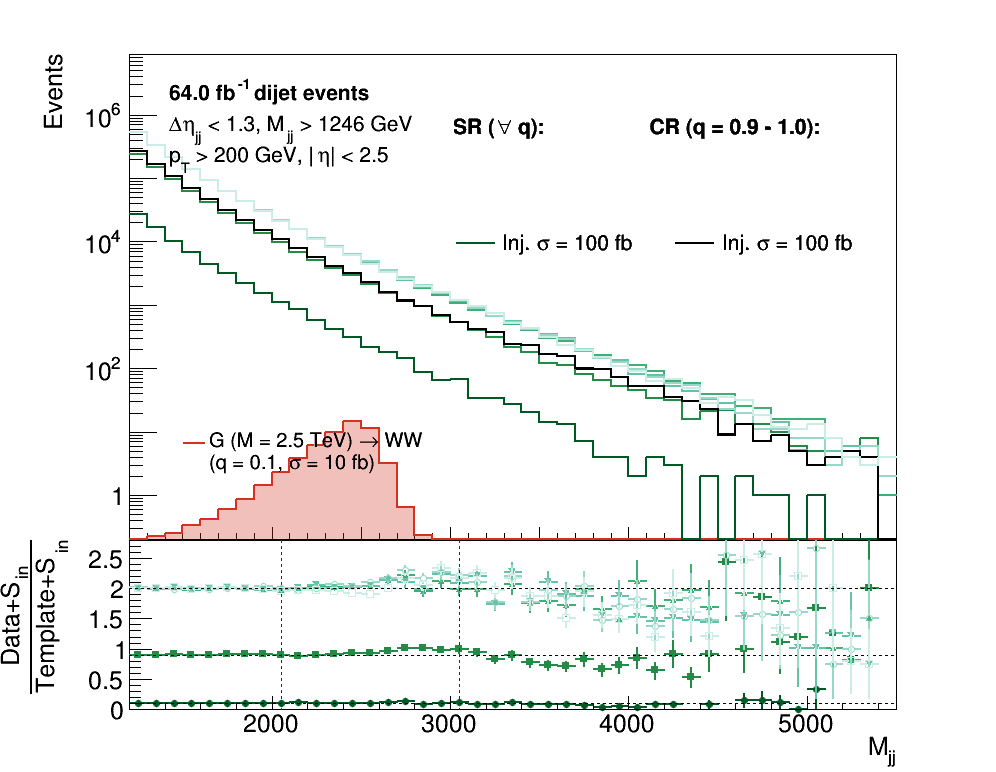

In [12]:
# Make data with injected signal!
# Do some validation checks and plot data distribution with injected signal.
# Also make table with S/sqrt(B) over full dijet range and in mJJ window.

sig_inj_vals = [10]

data = {'q':[],'q_string':[],'sig_inj':[],'mjjmin':[],  'mjjmax':[], 'NQCD':[], 'NSIG':[],'SB':[],'NQCD_SLICE':[], 'NSIG_SLICE':[],'SB_SLICE':[]}
        
# These dictionaries will contain the 90-100% quantile with injected signal (data_hist_rej_inj_all)
# and the orthogonal quantiles with injected signal (data_hist_acc_inj_all). They will be saved to 'histfile'
# The format is data_hist_rej_inj_all[quantile][sig_injected]

data_hist_rej_inj_all = {}
data_hist_acc_inj_all = {}

#Define signal Mjj window as 20% of each side of MX. Only used for drawing purposes and S/sqrt(B) values
axis = background_hist_template.GetXaxis()
bmin = axis.FindBin(MX*0.8)
bmax  = axis.FindBin(MX*1.2)
mjjmin = axis.GetBinCenter(bmin)
mjjmax = axis.GetBinCenter(bmax)

# Helper function to round numbers for TeX table
def round_sig(x, sig=1):
    if x == 0.:
        return 0
    else:
        return round(x, sig-int(floor(log10(abs(x))))-1)


leg = rt.TLegend(0.48, 0.5, 0.89, 0.85)
#stick to no injecion for now
c_out = rt.TCanvas("ratio", "", 1000, 800)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
pad1.SetLogy()
pad1.SetTitle('')
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.45, 0.61, 0.89, 0.91)
leg.SetNColumns(2)
leg.SetTextSize(0.05)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize (0.03)
leg.SetTextFont( 62 )
leg.SetHeader('SR (#forall q):                  CR (q = 0.9 - 1.0):')
leg.SetTextSize (0.03)
leg.SetTextFont( 42 )
background_hist_template.Draw('HIST')
# draw red signal hist
histos_signal[0.1].Draw('HISTsame')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.2)
background_hist_template.SetMaximum(qcd_tot.shape[0]*1.2)
background_hist_template.GetYaxis().SetLabelSize(0.05)
background_hist_template.GetYaxis().SetTitleSize(0.05)


for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
#     if key == 1.0: #To skip reject quantile
#        continue
    prefix = 'q'+str(int(key*100))
#     print(prefix) 
#     print('Quantile integral = {}'.format(histos_data[key].Integral()))
#     print('Template integral = {} (10%efficiency)'.format(background_hist_template.Integral()))
#     print('Efficiency= {}'.format(histos_data[key].Integral()/background_hist_template.Integral()))
    
    data_hist_rej_inj = {}
    data_hist_acc_inj = {}
    for k,sig_inj in enumerate(sig_inj_vals):
        data_hist_rej_inj[sig_inj] = background_hist_template.Clone('background_hist_template_inj{}_{}'.format(sig_inj,prefix))
        data_hist_acc_inj[sig_inj] = histos_data[key].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,prefix))
        data_hist_rej_inj[sig_inj].Add(signal_hist_template,sig_inj)
        data_hist_acc_inj[sig_inj].Add(histos_signal[key],sig_inj)
        
        # Compute some useful S/B quantities and print as latex table
        if sig_inj != 0:
            data['q'].append(key)
            keystring = '{} - {}'.format(lower_bound,key)
            data['q_string'].append(keystring)
            data['sig_inj'].append(int(sig_inj*10.))
            data['mjjmin'].append(mjjmin)
            data['mjjmax'].append(mjjmax)
            NQCD       = int(histos_data[key].Integral())
            NSIG       = int(data_hist_acc_inj[sig_inj].Integral())-int(histos_data[key].Integral())
            SB         = round_sig(NSIG/np.sqrt(NQCD))
            NQCD_SLICE = int(histos_data[key].Integral(bmin,bmax))
            NSIG_SLICE = int(data_hist_acc_inj[sig_inj].Integral(bmin,bmax))-int(histos_data[key].Integral(bmin,bmax))
            SB_SLICE   = round_sig(NSIG_SLICE/np.sqrt(NQCD_SLICE))
            data['NQCD'].append(NQCD)
            data['NSIG'].append(NSIG)
            data['SB'].append(SB)
            data['NQCD_SLICE'].append(NQCD_SLICE)
            data['NSIG_SLICE'].append(NSIG_SLICE)
            data['SB_SLICE'].append(SB_SLICE)
        if key != 1.0:
            data_hist_acc_inj[sig_inj].SetLineColor(rt.TColor.GetColor(bcol[i]))
            data_hist_acc_inj[sig_inj].SetLineStyle(k+1)
            data_hist_rej_inj[sig_inj].SetLineStyle(k+1)
            data_hist_acc_inj[sig_inj].SetLineWidth(2)
            data_hist_rej_inj[sig_inj].SetLineWidth(2)
            data_hist_rej_inj[sig_inj].Draw('sameHIST')
            data_hist_acc_inj[sig_inj].Draw('sameHIST')
        if key == 0.01:
            leg.AddEntry(data_hist_acc_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
            leg.AddEntry(data_hist_rej_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
            
        
    data_hist_rej_inj_all[key] = data_hist_rej_inj
    data_hist_acc_inj_all[key] = data_hist_acc_inj
    
dataP = pandas.DataFrame(data)
dataP.to_pickle('Yields.pkl')
print(dataP.to_latex(columns=['q_string','sig_inj','NQCD','NSIG','SB','NQCD_SLICE','NSIG_SLICE','SB_SLICE'],header=['q','$\sigma$ [fb]','$N_{bkg}$','$N_{sig}$','$S/\sqrt{B}$','$N_{bkg}$ ($M_{X} \pm 10\%$)','$N_{sig}$ ($M_{X} \pm 10\%$)','$S/\sqrt{B}$ ($M_{X} \pm 10\%$)'],index=False,escape=False)) 
leg2 = rt.TLegend(0.18, 0.12, 0.3, 0.2)
leg2.SetBorderSize(0)
leg2.SetFillStyle(0)
leg2.SetTextSize (0.04)
leg2.SetTextFont( 42 )
leg2.AddEntry(histos_signal[0.1],'G (M = '+mG+'.5 TeV) #rightarrow WW','l')
leg2.AddEntry(None,'(q = 0.1, #sigma = 10 fb)','')
leg2.Draw('same')
c_out.Update()


# Add ratio SRinj/CRinj
c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio_all = {}
tline = {}
for i,key in enumerate(sorted(histos_data.keys())):
    if key == 1.0:
        continue
    data_hist_ratio = {}
    pad2.cd()
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
    
    for k,sig_inj in enumerate(sig_inj_vals):
        
        data_hist_ratio[sig_inj] = data_hist_acc_inj_all[key][sig_inj].Clone('data_hist_ratio_{}{}'.format(i,k))
        data_hist_ratio[sig_inj].Divide(data_hist_rej_inj_all[key][sig_inj])
        data_hist_ratio[sig_inj].binning = bin_edges

        if k == 0 and i == 0:
            data_hist_ratio[sig_inj].SetTitle('')
            data_hist_ratio[sig_inj].Draw('pez')
            data_hist_ratio[sig_inj].SetMaximum(2.8)
            data_hist_ratio[sig_inj].SetMinimum(0.0)
            data_hist_ratio[sig_inj].SetYTitle('#frac{Data+S_{in}}{Template+S_{in}}')
            data_hist_ratio[sig_inj].GetYaxis().SetTitleOffset(0.5)
            data_hist_ratio[sig_inj].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[sig_inj].Draw('pez same')
    
    data_hist_ratio_all[key] = data_hist_ratio
    
    tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')

vlineDown = rt.TLine(mjjmin, 0.0, mjjmin, 2.8)
vlineDown.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineDown.SetLineStyle(rt.kDashed)
vlineDown.Draw('same')
vlineUp = rt.TLine(mjjmax, 0.0, mjjmax, 2.8)
vlineUp.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineUp.SetLineStyle(rt.kDashed)
vlineUp.Draw('same')
c_out.cd()


latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.03)
latex.SetTextFont( 62 )
latex.DrawLatex (0.17 ,0.87 , "%.1f fb^{-1} dijet events"%lumi)
latex.SetTextSize (0.03)
latex.SetTextFont( 42 )
latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1246 GeV")
latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
leg.Draw('same')
c_out.SaveAs('sigInj_all.pdf')


leg.Draw('same')
c_out.Draw()       

In [13]:
# Make sure the data is correctly created and store all histograms to file (will be imported to workspace below)

outfile = rt.TFile(histfile, 'RECREATE' )

signal_hist_template.Write('signal_template')
background_hist_template.Write('background_template')
for i,qkey in enumerate(sorted(data_hist_acc_inj_all.keys())):
    quantile = int(qkey*100)
    histos_signal[qkey].Write('signal_q{}percent'.format(quantile))
    histos_data[qkey].Write('background_q{}percent'.format(quantile))
    for i,skey in enumerate(sorted(data_hist_acc_inj_all[key])):
        injected = int(skey*10.)
        prefix = 'inj{}fb_q{}percent'.format(injected,quantile)
        print('Quantile={} signalInj={}'.format(qkey,injected))
        print('{}: {} events'.format('data_acc_{}'.format(prefix),data_hist_acc_inj_all[qkey][skey].Integral()))
        data_hist_acc_inj_all[qkey][skey].Write('data_acc_{}'.format(prefix))
        data_hist_rej_inj_all[qkey][skey].Write('data_rej_{}'.format(prefix))


outfile.Close()        

Quantile=0.01 signalInj=100
data_acc_inj100fb_q1percent: 76152.1272922 events
Quantile=0.1 signalInj=100
data_acc_inj100fb_q10percent: 689969.118415 events
Quantile=0.3 signalInj=100
data_acc_inj100fb_q30percent: 1534989.13794 events
Quantile=0.5 signalInj=100
data_acc_inj100fb_q50percent: 1534497.20559 events
Quantile=0.7 signalInj=100
data_acc_inj100fb_q70percent: 1538668.14965 events
Quantile=0.9 signalInj=100
data_acc_inj100fb_q90percent: 1533698.21433 events
Quantile=1.0 signalInj=100
data_acc_inj100fb_q100percent: 766278.506887 events


In [14]:
def makeWS(data_rej,data_acc,signal_rej,signal_acc, outname, quantile,injectedSignal, bg_eff, sig_eff):
  
  efficiency = sig_eff/bg_eff #data_acc.Integral()/data_rej.Integral() #How much rej histogram needs to be scaled to match acc
  print('Using efficiency = {} '.format(efficiency))
  
  xaxis = data_acc.GetXaxis().GetXbins()
  min_bin = xaxis[0]
  max_bin = xaxis[len(xaxis)-1]
  n_bins  = len(xaxis)-1
  # set up workspace
  datacard_ws = rt.TFile.Open(outname,'recreate')
  w = rt.RooWorkspace('w','w')
  x = rt.RooRealVar('x','x',min_bin,max_bin)
  w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

  acc_bin_functions = rt.RooArgList()
  rej_bin_functions = rt.RooArgList()
  w.factory('eff[%f]'%(efficiency))
  w.var('eff').setConstant(True)

  empty_hist = rt.TH1D('empty_hist','empty_hist', data_rej.GetNbinsX(), data_rej.GetXaxis().GetXbins().GetArray())
  # empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
  for iBinX in range(1,data_rej.GetNbinsX()+1):
      empty_hist.SetBinContent(iBinX,1)
      w.factory('crBin%i_In[%.1f]'%(iBinX,data_rej.GetBinContent(iBinX)))
      w.factory('crBin%i[0,-100,100]'%(iBinX))
      w.var('crBin%i_In'%iBinX).setConstant(True)
      w.var('crBin%i'%iBinX).setConstant(False)
      if data_rej.GetBinContent(iBinX) !=  0.:
        power = 1/rt.TMath.Sqrt(data_rej.GetBinContent(iBinX))
      else:
        power = -1.0
        w.var('crBin%i'%iBinX).setConstant(True)
      #what is fit is actually (mjj+mjj/sqrt(mjj))^x_bin, meaning x_bin is representative of how many sigma acc is from rej
      w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,power,iBinX,iBinX))
      # w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(data_rej.GetBinContent(iBinX)),iBinX,iBinX))
      w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
      rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
      acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
  qcd_rph_rej = rt.RooParametricHist('background_rej','background_rej',w.var('x'),rej_bin_functions,empty_hist)
  qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
  qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
  qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
  getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
  getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
  getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
  getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

  ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_acc)
  ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_rej)
  getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
  getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

  ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),data_acc)
  ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),data_rej)
  getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
  getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

  datacard_ws.cd()
  w.Write()
  datacard_ws.Close()

  # w.Print('v')
  
  datacard_ratio = \
  '''
  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * {WS} w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin {BIN}
  observation {OBS}
  ------------------------------
  bin             {BIN}      {BIN}
  process         signal     background
  process         0          1
  rate            {SIGRATE}    {BKGRATE}
  --------------------------------
  lumi lnN 1.01 -
  eff   flatParam
  '''

  for i in range(1,n_bins+1):
      datacard_ratio += 'crBin%i   flatParam\n'%i
  
  # write datacard
  datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                            OBS=-1,
                            BKGRATE=1,
                            SIGRATE=signal_acc.Integral(),
                            WS=outname)
  print(datacard_ratio_acc)
  with open(outname.replace('.root','_acc.txt'),'w') as f:
      f.write(datacard_ratio_acc)
    
    
  datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                            OBS=-1,
                            BKGRATE=1,
                            SIGRATE=signal_rej.Integral(),
                            WS=outname)
  print(datacard_ratio_rej)
  with open(outname.replace('.root','_rej.txt'),'w') as f:
      f.write(datacard_ratio_rej)
  os.system('combineCards.py rej={REJ} acc={ACC} > {RATIO}'.format(REJ=outname.replace('.root','_rej.txt'),ACC=outname.replace('.root','_acc.txt'),RATIO=outname.replace('.root','_ratio.txt')))
  

In [15]:
#histfile = 'histograms_200GeV_5600.root'
lumi = 60
#Only lool at one quantile/signal injection for debugging
sig_inj_vals = [0] #These correspond to xsecs of 0fb(used for GOF w.o signal), 1fb, 10fb, 20fb, 50fb, 100fb
quants       = [0.01]

doCombine = True #If run combine
doPlots = False # If you already ran combine and only want to plot results. Currently only running combine and debugging below


for i,qkey in enumerate(quants):

    if i > 0:
      lower_bound = quants[i-1]
    else:
      lower_bound = 0.0

    for skey in sig_inj_vals:
      injectedSignal = int(skey*10.) #Stick to no injected signal for now
      quantile       = int(qkey*100)
      prefix = 'inj{}fb_q{}percent'.format(injectedSignal,quantile) #different name for all quantiles/injected signal

      # Get histograms
      f = rt.TFile.Open(histfile,"r")
      data_rej = f.Get('data_rej_{}'.format(prefix)); data_rej.SetDirectory(0);
      data_acc = f.Get('data_acc_{}'.format(prefix)); data_acc.SetDirectory(0);
      efficiency = data_acc.Integral()/data_rej.Integral()

      signal_acc     = f.Get('signal_q{}percent'.format(quantile)) ; signal_acc.SetDirectory(0);
      signal_rej     = f.Get('signal_template') ; signal_rej.SetDirectory(0);
      f.Close() 

      xaxis = data_acc.GetXaxis().GetXbins()
      min_bin = xaxis[0]
      max_bin = xaxis[len(xaxis)-1]
      n_bins  = len(xaxis)-1

      makeWS(data_rej,data_acc,signal_rej,signal_acc, outname='datacard_ws_{PREFIX}.root'.format(PREFIX=prefix), quantile=quantile,injectedSignal=injectedSignal, bg_eff=0.1, sig_eff=qkey)
      if doCombine:
        os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_{PREFIX}_ratio.txt -n Ratio_gof_{PREFIX} --dataset data_obs -v 0'.format(PREFIX=prefix))
        for i in range(1):
          os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_{PREFIX}_ratio.txt -t 200 --toysFreq -n Ratio_gof_toys_{PREFIX}  --dataset data_obs -s {S} -v 0'.format(PREFIX=prefix,S=40+i))
        os.system('hadd -f higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.4*.root'.format(PREFIX=prefix))

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]
        print("Obs gof = {}".format(obs_gof))
        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix))
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
        print("Exp gof (mean) = {}".format(np.mean(exp_gof)))


      if doPlots:

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix)) #limit contains the value of the test-statistic in each toy
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total

        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        # print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))

        bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
        exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        for g in exp_gof:
            exp_gof_hist.Fill(g)
            if g > obs_gof:
                exp_gof_hist_gt.Fill(g)


        d = rt.TCanvas("ratio", "", 1000, 800)
        d.SetLeftMargin(0.13)
        # signal_hist_template    .Draw('same HIST')

        rt.gStyle.SetOptTitle(0)
        rt.gStyle.SetOptStat(0)
        f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))

        tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
        tleg.SetTextSize(0.05)
        tleg.SetBorderSize(0)
        tleg.SetFillStyle(0)
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 62 )
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 42 )
        exp_gof_hist.Draw('hist')
        exp_gof_hist.SetXTitle('Test statistic -2ln#lambda')
        exp_gof_hist.SetYTitle('N toys')
        exp_gof_hist.SetTitle("")
        exp_gof_hist.GetYaxis().SetLabelSize(0.05)
        exp_gof_hist.GetYaxis().SetTitleSize(0.05)
        f.SetLineColor((rt.TColor.GetColor(scol[1])))
        exp_gof_hist.SetLineWidth(2)
        exp_gof_hist.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetFillColorAlpha((rt.TColor.GetColor(bcol[0])), 0.30)
        exp_gof_hist_gt.Draw('fhistsame')
        f.Draw('same')
        line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
        line.SetLineWidth(2)
        line.Draw()
        tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
        tleg.AddEntry(f,'p-value (from #chi^{2}) = %.2f'%pval,'l')
        tleg.AddEntry(line,'Observed (Best fit = {:.1f})'.format(obs_gof),'l')
        tleg.Draw()
        latex = rt.TLatex()
        latex.SetNDC ()
        latex.SetTextSize (0.03)
        latex.SetTextFont( 62 )
        latex.DrawLatex (0.67 ,0.27 , "%.1f fb^{-1} dijet events"%lumi)
        latex.SetTextSize (0.03)
        latex.SetTextFont( 42 )
        latex.DrawLatex(0.67 ,0.23 , 'q = {} - {}'.format(lower_bound,qkey))
        # latex.DrawLatex(0.67 ,0.19 , "Acc./rej. = {:.2f}".format(efficiency))
        # latex.DrawLatex(0.67 ,0.15 , "50 GeV binning")
        # d.Draw()
        d.SaveAs('gof_{}.pdf'.format(prefix))

        # # by hand GOF calculation
        os.system('combine -M FitDiagnostics -d datacard_ws_{PREFIX}_ratio.txt -n _fit_result_{PREFIX} --saveShapes --saveWithUncertainties --dataset data_obs'.format(PREFIX=prefix))
        fitDiag = rt.TFile.Open('fitDiagnostics_fit_result_{PREFIX}.root'.format(PREFIX=prefix),'r')

        byhand_gof = 0
        bw = 100
        f = rt.TCanvas('f','f',1000,800)
        f.cd()
        for cat in ['rej', 'acc']:
            bkgd = fitDiag.Get('shapes_fit_b/{cat}/background'.format(cat=cat))
            if not bkgd:
              continue
            bkgd.Scale(bw) # need to multiply by bin width for some reason?
            data = fitDiag.Get('shapes_fit_b/{cat}/data'.format(cat=cat))
            if cat=='rej':
                bkgd.Draw('hist')
                bkgd.SetMinimum(5000)
                bkgd.SetMaximum(15000)
                bkgd.GetXaxis().SetRangeUser(100,1700)
            else:
                bkgd.Draw("histsame")
            data.SetMarkerStyle(20)
            data.SetMarkerColor(rt.kBlack)
            for i in range(0,bkgd.GetNbinsX()):
                bw = bkgd.GetBinWidth(i)
                data.SetPointEXlow(i,0)
                data.SetPointEXhigh(i,0)
                data.SetPoint(i,data.GetX()[i], bw*data.GetY()[i]) # need to multiply by bin width for some reason?
                data.SetPointEYlow(i,bw*data.GetErrorYlow(i)) # need to multiply by bin width for some reason?
                data.SetPointEYhigh(i,bw*data.GetErrorYhigh(i)) # need to multiply by bin width for some reason?
            data.Draw('samepez')


            for i in range(0,bkgd.GetNbinsX()):
                x = bkgd.GetBinCenter(i+1)
                fi = bkgd.GetBinContent(i+1)
                di = data.GetY()[i]
                gofi = 2*(fi - di + di*rt.TMath.Log(di/fi)) # see eq. 14 of http://cousins.web.cern.ch/cousins/ongoodness6march2016.pdf

                # expect each bin to give GOF contribution ~ O(1)
                if gofi>5:
                    print('Bin center {}'.format(x))
                    print('{cat} bin {i}: fi={fi}, di={di}, gofi={gofi}'.format(cat=cat,i=i,fi=fi,di=di,gofi=gofi))
                    print(" -> BIG GOF CONTRIBUTION in this bin")
                byhand_gof += gofi
            f.SetLogy()
            f.Draw()
            fitDiag.Close()
        print("by hand obs GOF = {}".format(byhand_gof))
        print("combine obs GOF = {}".format(obs_gof))
        print("combine exp GOF = {}".format(np.mean(exp_gof)))

        print("Done with quantile ",qkey )
        print("p-value = {}".format(pval_toys))
        print("Observed GOF = {}".format(obs_gof))

AttributeError: 'TObject' object has no attribute 'SetDirectory'

In [ ]:
# DEBUG! Plot GOF
n_bins = background_hist_template.GetNbinsX()
print n_bins
prefix = "inj0fb_q1percent"
obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix)) #limit contains the value of the test-statistic in each toy
exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

# get p-value from toys
n_extreme = len(exp_gof[exp_gof > obs_gof])
n_total = len(exp_gof)
pval_toys = 1.*n_extreme/n_total

# get p-value assuming chi2 dist (may not be valid)
pval = rt.TMath.Prob(obs_gof,n_bins)
# print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))

bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
for g in exp_gof:
    exp_gof_hist.Fill(g)
    if g > obs_gof:
        exp_gof_hist_gt.Fill(g)


d = rt.TCanvas("ratio", "", 1000, 800)
d.SetLeftMargin(0.13)
# signal_hist_template    .Draw('same HIST')

rt.gStyle.SetOptTitle(0)
rt.gStyle.SetOptStat(0)
f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))

tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
tleg.SetTextSize(0.05)
tleg.SetBorderSize(0)
tleg.SetFillStyle(0)
tleg.SetTextSize (0.03)
tleg.SetTextFont( 62 )
tleg.SetTextSize (0.03)
tleg.SetTextFont( 42 )
exp_gof_hist.Draw('hist')
exp_gof_hist.SetXTitle('Test statistic -2ln#lambda')
exp_gof_hist.SetYTitle('N toys')
exp_gof_hist.SetTitle("")
exp_gof_hist.GetYaxis().SetLabelSize(0.05)
exp_gof_hist.GetYaxis().SetTitleSize(0.05)
f.SetLineColor((rt.TColor.GetColor(scol[1])))
exp_gof_hist.SetLineWidth(2)
exp_gof_hist.SetLineColor((rt.TColor.GetColor(bcol[0])))
exp_gof_hist_gt.SetLineColor((rt.TColor.GetColor(bcol[0])))
exp_gof_hist_gt.SetFillColorAlpha((rt.TColor.GetColor(bcol[0])), 0.30)
exp_gof_hist_gt.Draw('fhistsame')
f.Draw('same')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
tleg.AddEntry(f,'p-value (from #chi^{2}) = %.2f'%pval,'l')
tleg.AddEntry(line,'Observed (Best fit = {:.1f})'.format(obs_gof),'l')
tleg.Draw()
latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.03)
latex.SetTextFont( 62 )
latex.DrawLatex (0.67 ,0.27 , "%.1f fb^{-1} dijet events"%lumi)
latex.SetTextSize (0.03)
latex.SetTextFont( 42 )
latex.DrawLatex(0.67 ,0.23 , '{}'.format(prefix))
# latex.DrawLatex(0.67 ,0.23 , 'q = {} - {}'.format(lower_bound,qkey))
# latex.DrawLatex(0.67 ,0.19 , "Acc./rej. = {:.2f}".format(efficiency))
# latex.DrawLatex(0.67 ,0.15 , "50 GeV binning")
d.Draw()

In [ ]:
#DEBUG! Plot fit results!

import math
os.system('combine -M FitDiagnostics -d datacard_ws_{PREFIX}_ratio.txt -n _fit_result_{PREFIX} --saveShapes --saveWithUncertainties --dataset data_obs'.format(PREFIX=prefix))
fitDiag = rt.TFile.Open('fitDiagnostics_fit_result_{PREFIX}.root'.format(PREFIX=prefix),'r')


f = rt.TCanvas('f','f',1000,800)
f.cd()

tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
tleg.SetTextSize(0.05)
tleg.SetBorderSize(0)
tleg.SetFillStyle(0)
tleg.SetTextSize (0.03)
tleg.SetTextFont( 62 )
tleg.SetTextSize (0.03)
tleg.SetTextFont( 42 )

byhand_gof = 0.0
for cat in ['rej', 'acc']:
    print cat
    bkgd = fitDiag.Get('shapes_fit_b/{cat}/background'.format(cat=cat))
    bkgd.Scale(100) # need to multiply by bin width for some reason?
    data = fitDiag.Get('shapes_fit_b/{cat}/data'.format(cat=cat))
    if cat=='rej':
        bkgd.Draw('hist')
        bkgd.SetLineColor(rt.kRed)
#         bkgd.SetMinimum(10E3)
#         bkgd.SetMaximum(20E3)
#         bkgd.GetXaxis().SetRangeUser(1400,1500)
        tleg.AddEntry(bkgd,'rej','l')
    else:
        bkgd.Draw("histsame")
        tleg.AddEntry(bkgd,'acc','l')
    data.SetMarkerStyle(20)
    data.SetMarkerColor(rt.kBlack)
    for i in range(0,bkgd.GetNbinsX()):
        data.SetPointEXlow(i,0)
        data.SetPointEXhigh(i,0)
        data.SetPoint(i,data.GetX()[i], 100*data.GetY()[i]) # need to multiply by bin width for some reason?
        data.SetPointEYlow(i,100*data.GetErrorYlow(i)) # need to multiply by bin width for some reason?
        data.SetPointEYhigh(i,100*data.GetErrorYhigh(i)) # need to multiply by bin width for some reason?
    data.Draw('samepez')
    

    for i in range(0,bkgd.GetNbinsX()):
        mjjvalue = bkgd.GetBinCenter(i+1)
        fi = bkgd.GetBinContent(i+1)
        di = data.GetY()[i]
        if di == 0:
            print ("No data at mjj", mjjvalue)
            print ("fi", fi)
            print ("di", di)
            gofi = 0.
        else:    
            gofi = 2*(fi - di + di*rt.TMath.Log(di/fi)) # see eq. 14 of http://cousins.web.cern.ch/cousins/ongoodness6march2016.pdf
        # expect each bin to give GOF contribution ~ O(1)
        if gofi>5:
            print('{cat} bin {i}: fi={fi}, di={di}, gofi={gofi}'.format(cat=cat,i=i,fi=fi,di=di,gofi=gofi))
            print(" -> BIG GOF CONTRIBUTION in this bin, mjj {}".format(mjjvalue))
        byhand_gof += gofi

tleg.Draw('same')
f.SetLogy()
f.Draw()

print("Done with quantile ",prefix )

print("By hand obs GOF = {}".format(byhand_gof))
print("Combine obs GOF = {}".format(obs_gof))
print("Combine exp GOF (mean) = {}".format(np.mean(exp_gof)))

print("p-value = {}".format(pval_toys))
        